In [4]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import pickle
from scipy.optimize import curve_fit

## Virtualization
import matplotlib.pyplot as plt
import seaborn as sns

# ## res settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 10

## Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer # Standardize by default
from sklearn.preprocessing import StandardScaler

## Clustering
from sklearn.mixture import GaussianMixture

RANDOM_STATE = 4000

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [5]:
data = pd.read_pickle(r'data/train_sc.data')
data['ERT'] = None

In [6]:
dataCarb = data[data['Lithology'] == 'carbonate']
dataCarb.describe()

,Porosity,Formation Resistivity Factor,EQI
count,2143.000000,2143.000000,2143.000000
mean,0.134141,130.119809,0.313387
std,0.068958,112.040798,0.106178
min,0.023121,5.791307,0.103618
25%,0.072931,58.031920,0.236440
50%,0.123294,100.761458,0.301215
75%,0.182916,167.992776,0.372191
max,0.453092,1603.522546,0.846085


In [7]:
dataSand = data[data['Lithology'] == 'sandstone']
dataSand.describe()

,Porosity,Formation Resistivity Factor,EQI
count,1311.000000,1311.000000,1311.000000
mean,0.096697,118.156360,0.370098
std,0.033492,99.099424,0.105245
min,0.037732,8.650383,0.170489
25%,0.074273,48.798225,0.281944
50%,0.087794,92.839882,0.349013
75%,0.111470,156.650674,0.451269
max,0.279581,743.425908,0.697036


In [8]:
# AIC & BIC tests
def AicAndBic(data, Lithology, minComponents, maxCompornents):
    n_components = np.arange(minComponents, maxCompornents)
    models_test_tied = [GaussianMixture(n, covariance_type='tied', random_state=RANDOM_STATE).fit(data['EQI'].values.reshape(-1, 1))
                        for n in n_components]
    BIC = pd.DataFrame({
        'n_components': n_components, 
        'BIC - tied': [m.bic(data['EQI'].values.reshape(-1, 1)) for m in models_test_tied]})
    AIC = pd.DataFrame({
        'n_components': n_components, 
        'AIC - tied': [m.aic(data['EQI'].values.reshape(-1, 1)) for m in models_test_tied]})
    
    aic_indexes = AIC[['AIC - tied']].idxmin().values
    print(f'AIC - Suggested number of components for {Lithology}:', AIC.iloc[aic_indexes]['n_components'].values)
    print('min AIC value: ', AIC.iloc[aic_indexes]['AIC - tied'])
    bic_indexes = BIC[['BIC - tied']].idxmin().values
    print(f'BIC - Suggested number of components for {Lithology}:', BIC.iloc[bic_indexes]['n_components'].values)
    print('min BIC value: ', BIC.iloc[bic_indexes]['BIC - tied'])
    
    sns.set_palette(sns.color_palette('husl'))
    sns.lineplot( x='n_components', y='BIC - tied' ,data = BIC, color = sns.color_palette('husl')[0], label='BIC')
    sns.lineplot( x='n_components', y='AIC - tied' ,data = AIC, color = sns.color_palette('husl')[3], label='AIC')
    plt.title(Lithology)
    plt.xlabel('Number of Components')
    plt.ylabel('Information Criteria Value')

AIC - Suggested number of components for carbonate: [8]
min AIC value:  6   -3796.393861
Name: AIC - tied, dtype: float64
BIC - Suggested number of components for carbonate: [5]
min BIC value:  3   -3730.202976
Name: BIC - tied, dtype: float64


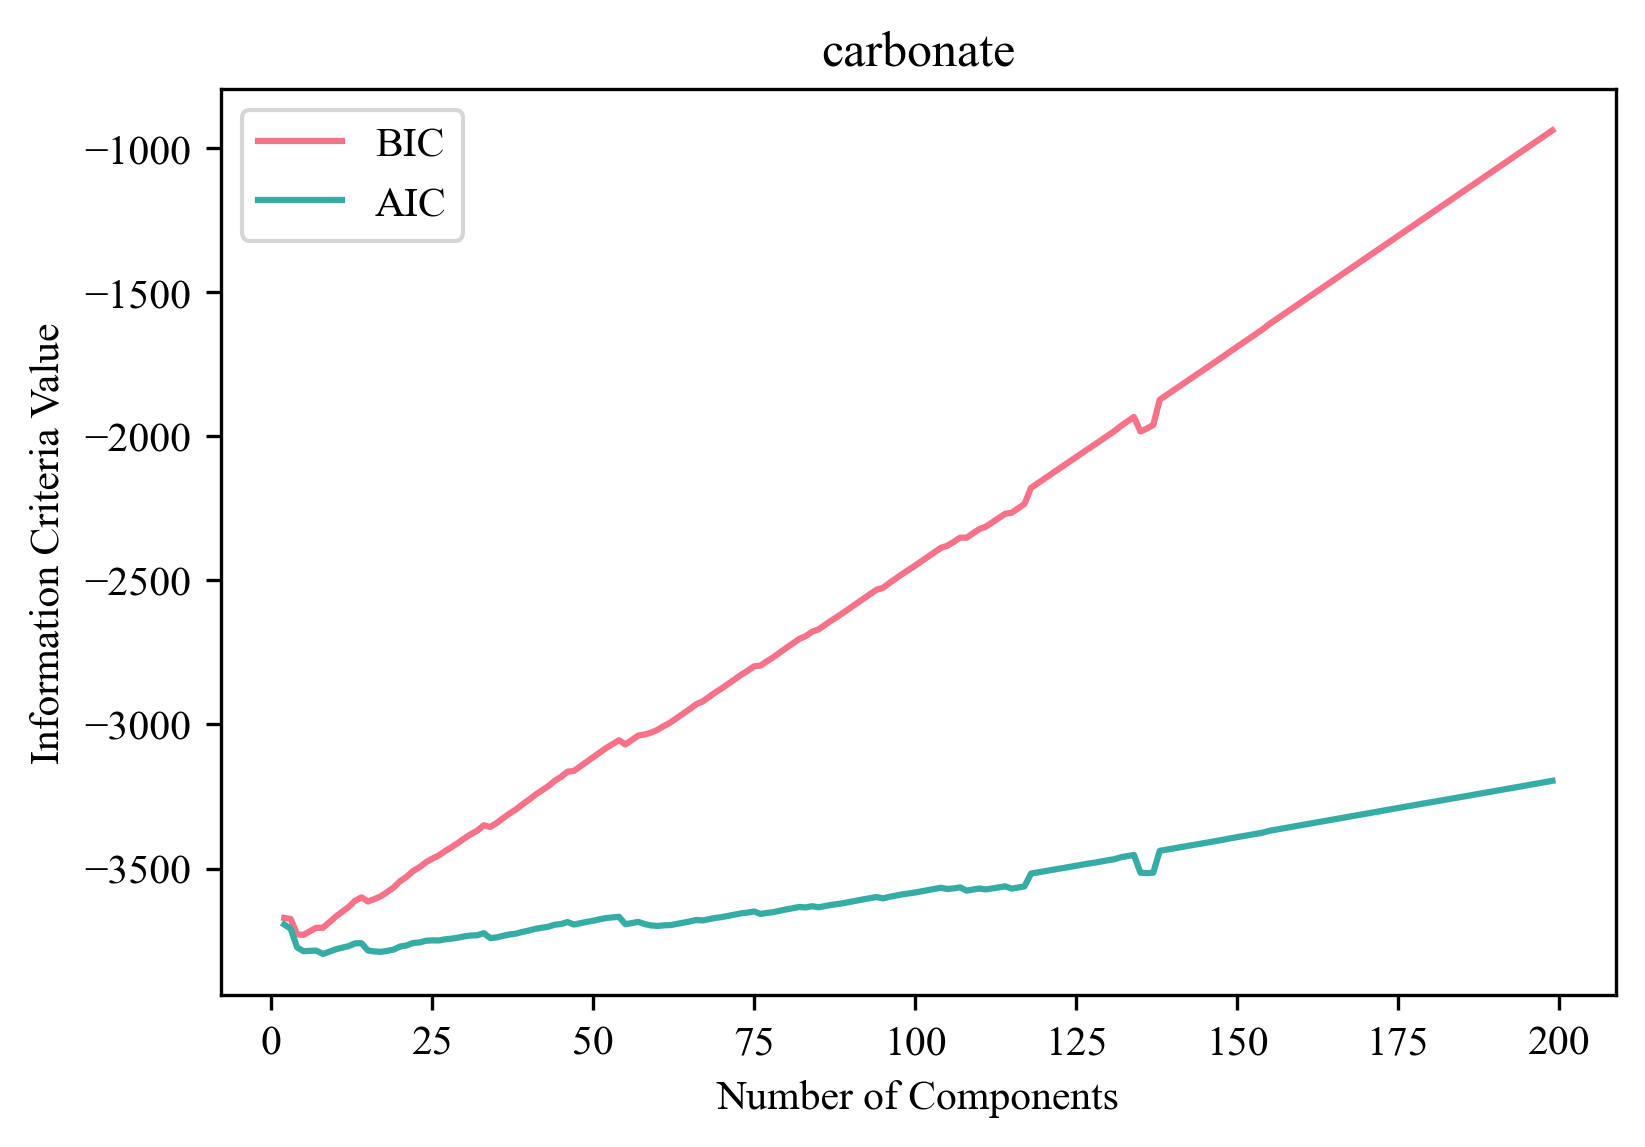

In [9]:
AicAndBic(dataCarb, 'carbonate', 2, 200)

In [ ]:
AicAndBic(dataSand, 'sandstone', 2, 200)

In [ ]:
## curve fitting
_R2s = []
_ms=[]
_as=[]
def power_law_data(x, a, b):
    return a*np.power(x, b)

def values_and_rquared_data(model_predictions, data,i):
    absError = model_predictions - data[data['ERT'] == i]['Formation Resistivity Factor']
    Rsquared = 1.0 - (np.var(absError) / np.var(data[data['ERT'] == i]['Formation Resistivity Factor']))
    _R2s.append(Rsquared)
    print('R-squared:', Rsquared)
    

def testModels(nComponents, data):
    cl_model = GaussianMixture(n_components = nComponents, covariance_type='tied', random_state=RANDOM_STATE) #63
    clusters= cl_model.fit_predict(data['EQI'].values.reshape(-1, 1))
    data['ERT'] = clusters + 1
    print(data.groupby('ERT').describe()['EQI'])
    print('*' * 50)
    
    for i in np.sort(pd.unique(data['ERT'])):
        popt, _ = curve_fit(power_law_data, data[data['ERT'] == i]['Porosity'],  data[data['ERT'] == i]['Formation Resistivity Factor'])
        # summarize the parameter values
        a, b = popt
        _ms.append(b)
        _as.append(a)
        modelPredictions = power_law_data(data[data['ERT'] == i]['Porosity'], a,b)
        print('ERT ', i, ': F = %.5f * φ ^ %.5f' % (a, b))
        values_and_rquared_data(modelPredictions, data,i)

In [ ]:
# model 1
testModels(8, dataCarb)

In [ ]:
# model 2
testModels(5, dataCarb)

In [ ]:
# model 3
testModels(3, dataSand)